<a href="https://colab.research.google.com/github/amritgos/MTP/blob/main/Portfolio_Model_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/amritgos/FinRL.git

  Cloning https://github.com/amritgos/FinRL.git to /tmp/pip-req-build-blj6h990
  Running command git clone -q https://github.com/amritgos/FinRL.git /tmp/pip-req-build-blj6h990
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-uw9hqp2z/pyfolio_4e2e8f43031e4619a0f1097b9ca765a6
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-uw9hqp2z/pyfolio_4e2e8f43031e4619a0f1097b9ca765a6


In [ ]:
!git clone https://github.com/amritgos/FinRL.git

fatal: destination path 'FinRL' already exists and is not an empty directory.


In [ ]:
cd FinRL

/content/FinRL


In [ ]:
!pip install tsmoothie

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from tsmoothie.smoother import *
from tsmoothie.utils_func import create_windows

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [ ]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.SENSEX_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2008-01-01,110.099998,114.400002,110.099998,99.300545,80500.0,ASIANPAINT.BO,1
1,2008-01-01,195.990005,196.570007,193.000000,174.035278,160755.0,AXISBANK.BO,1
2,2008-01-01,2567.529053,2589.146240,2555.737793,2509.898193,10177.0,BAJAJFINSV.BO,1
3,2008-01-01,44.153217,44.153217,40.369350,37.717117,202188.0,BAJFINANCE.BO,1
4,2008-01-01,463.589844,463.589844,442.475830,420.133118,432930.0,BHARTIARTL.BO,1


In [ ]:
def add_covariance_matrix(df):
    # add covariance matrix as states
    df=df.sort_values(['date','tic'],ignore_index=True)
    df.index = df.date.factorize()[0]

    cov_list = []
    return_list = []

    # look back is one year
    lookback=252
    for i in range(lookback,len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i,:]
        price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
        return_lookback = price_lookback.pct_change().dropna()
        return_list.append(return_lookback)

        covs = return_lookback.cov().values 
        cov_list.append(covs)

    
    df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
    df = df.merge(df_cov, on='date')
    df = df.sort_values(['date','tic']).reset_index(drop=True)

    return df
        

In [ ]:
df_org = df.copy()
for ticker in df['tic'].unique():
  df_tic = df.loc[df.tic==ticker]
  smoother = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=252)
  smoother.smooth(df_tic['close'].T)
  close_smooth = smoother.smooth_data
  df.loc[df.tic==ticker,'close'] = close_smooth[0]


In [ ]:
processed = add_covariance_matrix(df)
processed = processed.drop('return_list', axis=1)
processed.head()

,date,open,high,low,close,volume,tic,day,cov_list
0,2009-01-13,88.400002,91.400002,88.400002,80.840354,25990.0,ASIANPAINT.BO,1,"[[6.252581947097209e-05, 4.675120797301197e-05..."
1,2009-01-13,91.180000,92.989998,86.730003,82.989676,5566945.0,AXISBANK.BO,1,"[[6.252581947097209e-05, 4.675120797301197e-05..."
2,2009-01-13,225.500000,225.500000,214.000000,157.108216,29692.0,BAJAJ-AUTO.BO,1,"[[6.252581947097209e-05, 4.675120797301197e-05..."
3,2009-01-13,185.711060,194.357925,183.254562,182.049682,8446.0,BAJAJFINSV.BO,1,"[[6.252581947097209e-05, 4.675120797301197e-05..."
4,2009-01-13,5.828807,5.877381,5.649086,5.444510,31169.0,BAJFINANCE.BO,1,"[[6.252581947097209e-05, 4.675120797301197e-05..."


In [ ]:
# vix_df = pd.read_csv('datasets/IndiaVIX_data.csv')
sentiment_df = pd.read_csv('datasets/Sentiment_Compiled.csv')
sentiment_df

,date,tweets,news,tic
0,2016-01-01,NaN,NaN,NaN
1,2016-01-01,NaN,NaN,NaN
2,2016-01-01,NaN,NaN,NaN
3,2016-01-01,NaN,NaN,NaN
4,2016-01-01,NaN,NaN,NaN
...,...,...,...,...
54835,2021-01-01,0.043554,0.086588,SUNPHARMA.BO
54836,2021-01-01,0.000000,0.131225,TCS.BO
54837,2021-01-01,0.009032,0.110170,TECHM.BO
54838,2021-01-01,0.000000,0.102403,TITAN.BO


In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    use_vix=False,
                    use_sentiment=True,
                    sentiment_df=sentiment_df,
                    user_defined_feature = True)

processed = fe.preprocess_data(processed)

processed_close = pd.merge(processed[['date','tic']],df_org[['date','tic','close']], on=['date','tic'], how='inner') 

processed['close'] = processed_close['close']

Successfully added technical indicators
Successfully added Sentiment Features
Successfully added user defined features


In [ ]:
train = data_split(processed, '2011-01-01','2019-01-01')
train

,date,open,high,low,close,volume,tic,day,cov_list,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,tweets,news,daily_return,return_lag_1,return_lag_2
0,2011-01-03,289.799988,294.880005,286.019989,260.549377,107300.0,ASIANPAINT.BO,0,"[[2.2357639950761873e-05, 6.304936056065322e-0...",4.493260,269.159926,240.173165,69.471226,109.793158,42.158291,249.864312,246.553488,0.000000,0.000000,-0.000981,0.000195,-0.000283
0,2011-01-03,271.450012,274.399994,268.429993,241.443100,1603895.0,AXISBANK.BO,0,"[[2.2357639950761873e-05, 6.304936056065322e-0...",-3.671556,247.990399,237.832701,37.171534,18.500022,2.515764,247.207613,262.461569,0.000000,0.000000,0.000971,0.004955,0.009734
0,2011-01-03,1559.949951,1564.949951,1470.000000,996.826416,114420.0,BAJAJ-AUTO.BO,0,"[[2.2357639950761873e-05, 6.304936056065322e-0...",-20.094227,1178.120229,1055.903770,33.601817,-35.404984,17.836804,1143.223081,1150.582303,0.000000,0.000000,-0.013361,-0.015606,-0.016089
0,2011-01-03,456.908142,466.635864,453.223419,440.109985,5717.0,BAJAJFINSV.BO,0,"[[2.2357639950761873e-05, 6.304936056065322e-0...",-1.851710,457.280224,437.560541,43.375585,19.502562,25.423807,449.443446,458.953597,0.000000,0.000000,-0.001101,-0.002148,-0.001887
0,2011-01-03,68.483635,68.488495,67.517021,62.775902,17478.0,BAJFINANCE.BO,0,"[[2.2357639950761873e-05, 6.304936056065322e-0...",-0.975795,63.676318,62.186969,37.220447,-21.967453,19.105803,64.206193,67.876446,0.000000,0.000000,-0.003225,-0.004211,-0.003224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,2018-12-31,429.799988,432.299988,425.649994,423.790863,464991.0,SUNPHARMA.BO,0,"[[1.8084949188172707e-05, 8.963962256089494e-0...",-20.889969,434.258131,397.462683,17.066285,-44.374998,34.631421,441.315121,504.007477,-0.033368,0.039227,0.007160,0.013867,0.015506
1968,2018-12-31,1901.000000,1910.150024,1887.000000,1782.154785,155314.0,TCS.BO,0,"[[1.8084949188172707e-05, 8.963962256089494e-0...",-8.639630,1905.397217,1777.284756,40.086960,-57.418973,28.829936,1822.763507,1824.483084,0.000000,0.046776,-0.001175,-0.003250,-0.005205
1968,2018-12-31,716.000000,724.200012,715.400024,626.325317,50512.0,TECHM.BO,0,"[[1.8084949188172707e-05, 8.963962256089494e-0...",0.502567,644.512969,634.054091,52.971241,102.261735,2.209113,638.817710,636.597126,0.000000,-0.124014,0.001528,0.004324,0.007767
1968,2018-12-31,928.000000,939.000000,920.700012,915.336731,163019.0,TITAN.BO,0,"[[1.8084949188172707e-05, 8.963962256089494e-0...",4.798545,922.050540,891.646888,63.951734,62.632510,14.175912,906.198723,859.300116,0.000000,0.031650,0.006323,0.014274,0.017776


In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list=[],
                sentiment_indicator_list=[],
                user_indicator_list=[],
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.sentiment_indicator_list = sentiment_indicator_list
        self.user_indicator_list = user_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        # self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list)+len(self.sentiment_indicator_list)+len(self.user_indicator_list),self.state_space))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (1+len(self.tech_indicator_list)+len(self.sentiment_indicator_list)+len(self.user_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        # state_array =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        # state_array = np.append(state_array, [self.data[sent].values.tolist() for sent in self.sentiment_indicator_list ], axis=0)
        # state_array = np.append(state_array, [self.data[user].values.tolist() for user in self.user_indicator_list ], axis=0)
        # self.state =  state_array

        state_array = np.zeros([1,self.state_space])
        if len(self.tech_indicator_list) > 0:
          state_array = np.append(state_array, [self.data[tech].values.tolist() for tech in self.tech_indicator_list], axis=0)
        state_array = np.append(state_array, [self.data[sent].values.tolist() for sent in self.sentiment_indicator_list ], axis=0)
        state_array = np.append(state_array, [self.data[user].values.tolist() for user in self.user_indicator_list ], axis=0)
        self.state =  state_array

        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]

            # state_array =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            # state_array = np.append(state_array, [self.data[sent].values.tolist() for sent in self.sentiment_indicator_list ], axis=0)
            # state_array = np.append(state_array, [self.data[user].values.tolist() for user in self.user_indicator_list ], axis=0)
            # self.state =  state_array

            state_array = [weights]
            if len(self.tech_indicator_list) > 0:
              state_array = np.append(state_array, [self.data[tech].values.tolist() for tech in self.tech_indicator_list], axis=0)
            state_array = np.append(state_array, [self.data[sent].values.tolist() for sent in self.sentiment_indicator_list ], axis=0)
            state_array = np.append(state_array, [self.data[user].values.tolist() for user in self.user_indicator_list ], axis=0)
            self.state =  state_array

            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)

            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # update portfolio risk
            port_variance = np.matmul(weights.T,np.matmul(self.covs,weights))

            # print('portfolio variance', port_variance)
            # print('weights', sum(weights))
            # print('portfolio returns', portfolio_return)

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            # self.reward = portfolio_return/np.sqrt(port_variance)
            self.reward = self.portfolio_value

            # self.reward = 1/np.sqrt(port_variance)

            self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]

        # state_array =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        # state_array = np.append(state_array, [self.data[sent].values.tolist() for sent in self.sentiment_indicator_list ], axis=0)
        # state_array = np.append(state_array, [self.data[user].values.tolist() for user in self.user_indicator_list ], axis=0)
        # self.state =  state_array

        state_array = np.zeros([1,self.state_space])
        if len(self.tech_indicator_list) > 0:
          state_array = np.append(state_array, [self.data[tech].values.tolist() for tech in self.tech_indicator_list], axis=0)
        state_array = np.append(state_array, [self.data[sent].values.tolist() for sent in self.sentiment_indicator_list ], axis=0)
        state_array = np.append(state_array, [self.data[user].values.tolist() for user in self.user_indicator_list ], axis=0)
        self.state =  state_array

        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 1000, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    # "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "sentiment_indicator_list": config.SENTIMENT_INDICATORS_LIST, 
    "user_indicator_list": config.USER_INDICATORS_LIST,
    "action_space": stock_dimension, 
    "reward_scaling": 100
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

Stock Dimension: 30, State Space: 30


In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
# initialize

# from torch.nn import Softsign, ReLU
# ppo_params ={'n_steps': 128, 
#              'ent_coef': 0.01, 
#              'learning_rate': 0.0025, 
#              'batch_size': 64, 
#             'gamma': 0.99}

# policy_kwargs = {
# #     "activation_fn": ReLU,
#     "net_arch": [1024, 1024, 1024, 256, 64], 
# #     "squash_output": True
# }


agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0025}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=60000)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0025}
Using cpu device
Logging to tensorboard_log/a2c/a2c_4
------------------------------------
| time/                 |          |
|    fps                | 276      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0025   |
|    n_updates          | 99       |
|    policy_loss        | 1.67e+10 |
|    std                | 0.984    |
|    value_loss         | 1.74e+17 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 288       |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.7     |
|    explained_variance | -1

In [ ]:
# agent = DRLAgent(env = env_train)
# DDPG_PARAMS = {"learning_rate": 0.0025}
# model_ddpg = agent.get_model(model_name="ddpg",model_kwargs = DDPG_PARAMS)

# trained_ddpg = agent.train_model(model=model_ddpg, 
#                              tb_log_name='ddpg',
#                              total_timesteps=50000)

In [ ]:
trade = data_split(processed,'2019-01-01', '2021-01-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:nan
Sharpe:  0.9192189397261374
hit end!


In [ ]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^BSESN", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (489, 8)
Annual return          0.158443
Cumulative returns     0.330292
Annual volatility      0.248750
Sharpe ratio           0.718724
Calmar ratio           0.416188
Stability              0.019371
Max drawdown          -0.380701
Omega ratio            1.160023
Sortino ratio          0.966249
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.947229
Daily value at risk   -0.030630
dtype: float64


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (490, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,23
,Backtest
Annual return,21.536%
Cumulative returns,46.118%
Annual volatility,23.412%
Sharpe ratio,0.96
Calmar ratio,0.61
Stability,0.17
Max drawdown,-35.119%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.12,2020-01-14,2020-03-18,2020-11-03,211
1,9.20,2019-05-29,2019-08-19,2019-09-18,81
2,4.86,2019-02-04,2019-02-14,2019-03-06,23
3,4.64,2019-09-18,2019-10-01,2019-10-14,19
4,4.62,2019-04-11,2019-05-10,2019-05-15,25


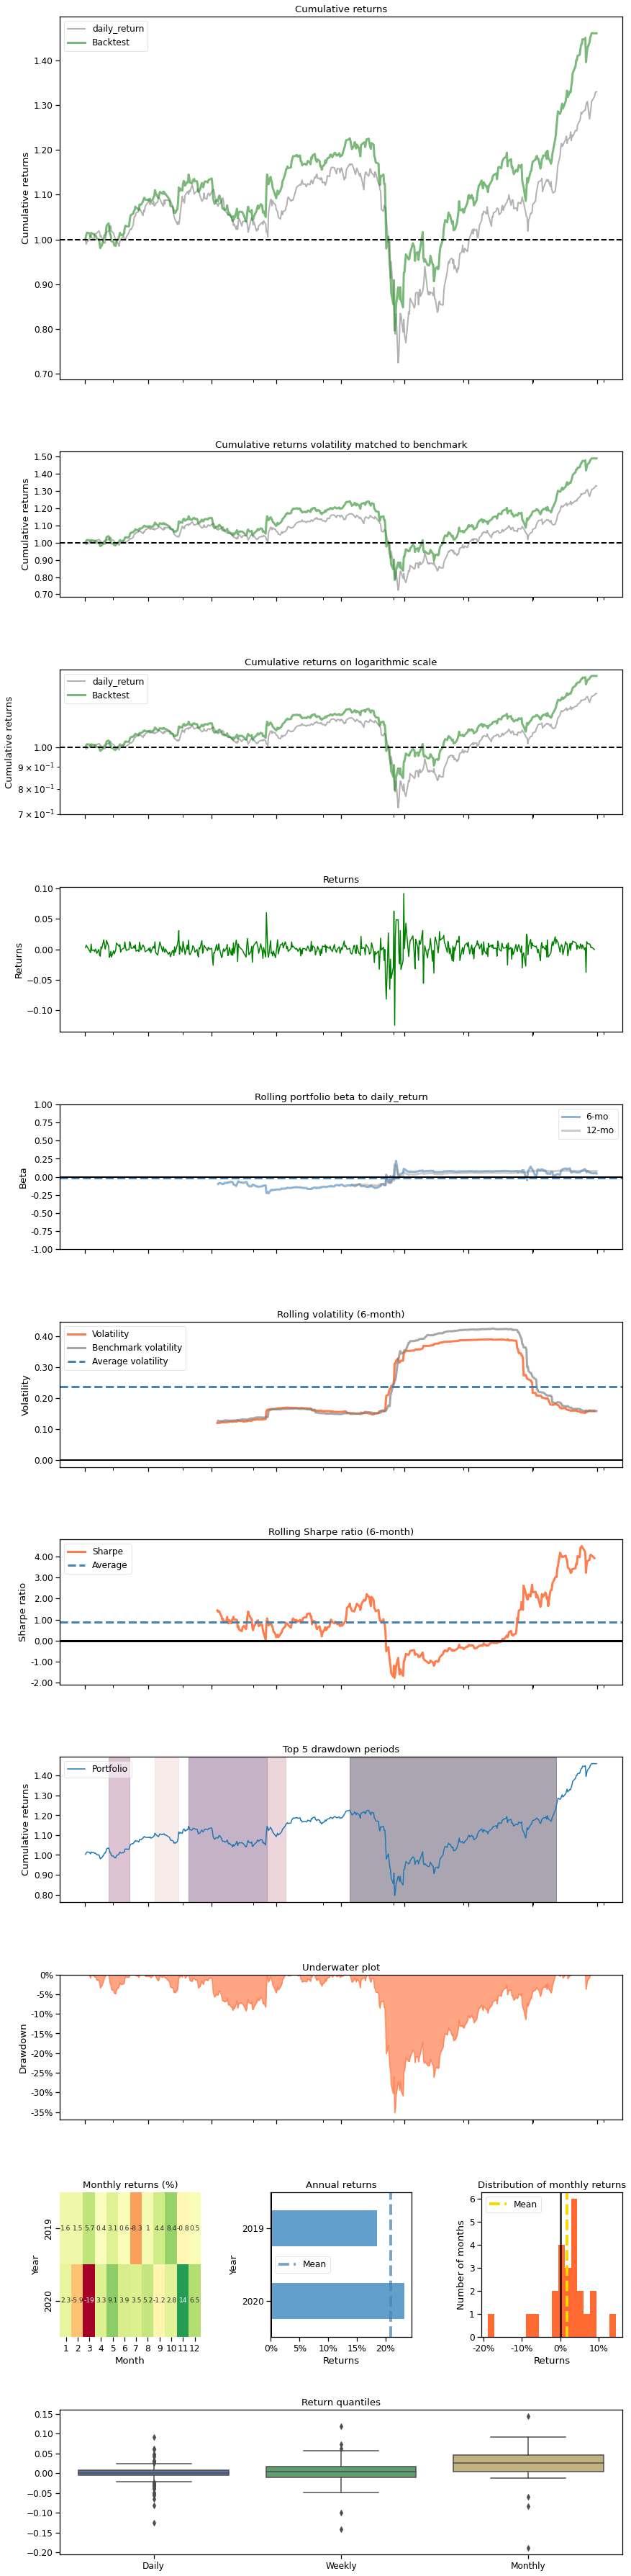

In [ ]:
import pyfolio
import datetime as dt
%matplotlib inline

baseline_df = get_baseline(
        ticker='^BSESN', start='2019-01-01', end='2021-01-01')


baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [ ]:
 df_daily_return.to_csv('df_returns_ret1.csv')